# **Hospital Stay Prediction** 

### NAME: **AVULA BHUMIKA**


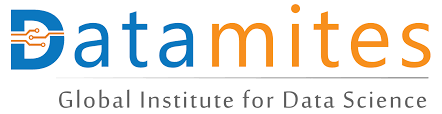!

### Load Dependencies

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_theme(style="whitegrid")      
plt.style.use('ggplot')


### TASK 1 Data Analytics

Dataset Shape: (318438, 18)
Columns: ['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available_Extra_Rooms_in_Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed_Grade', 'patientid', 'City_Code_Patient', 'Type_of_Admission', 'Severity_of_Illness', 'Visitors_with_Patient', 'Age', 'Admission_Deposit', 'Stay']
Data Types:
 case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available_Extra_Rooms_in_Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed_Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type_of_Admission                     object
Severity_of_Illness           

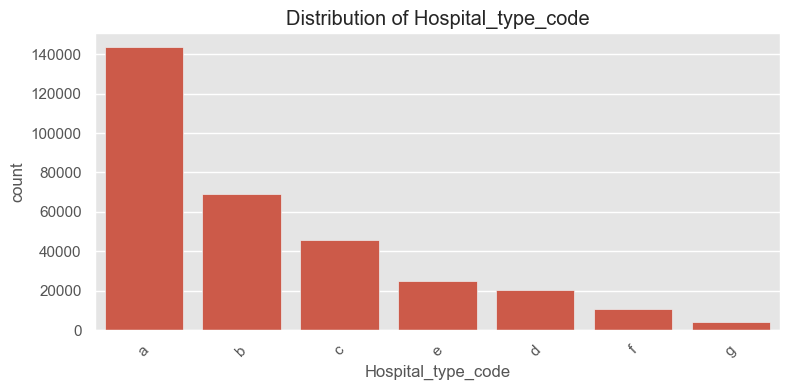

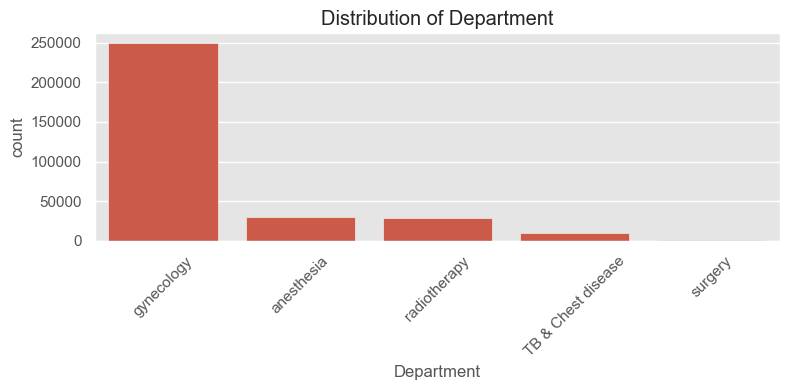

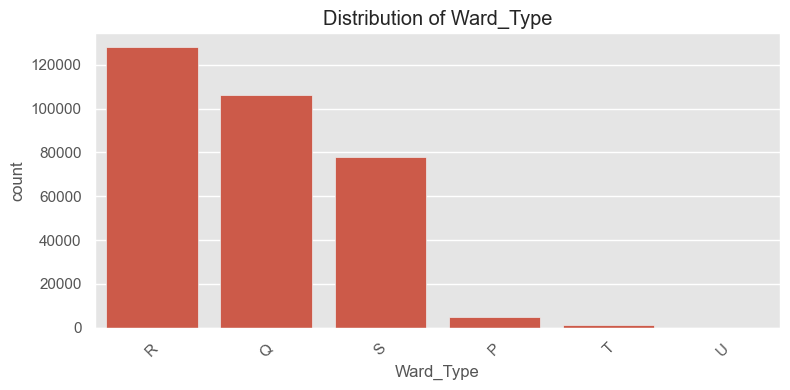

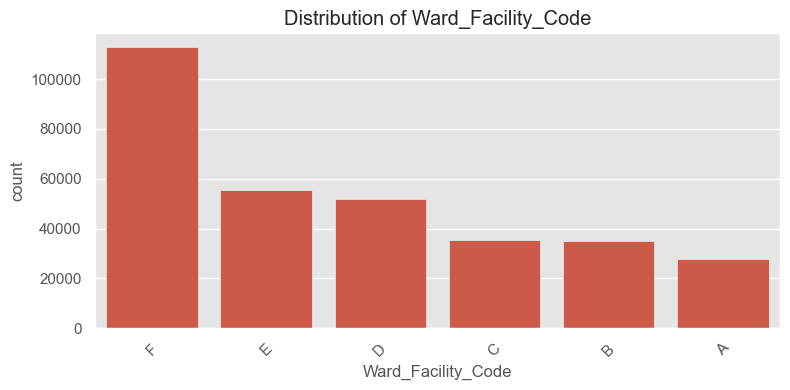

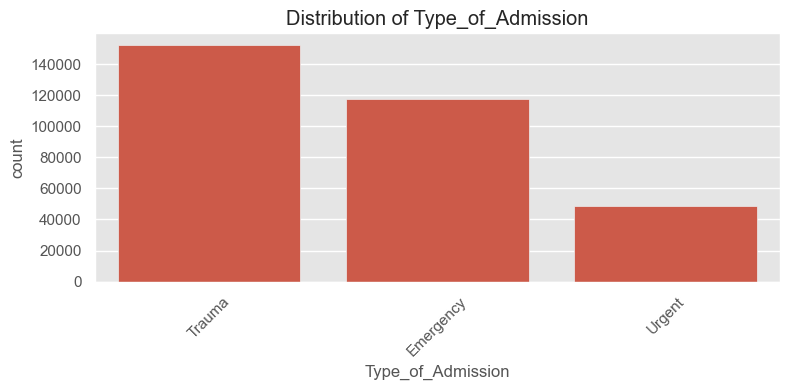

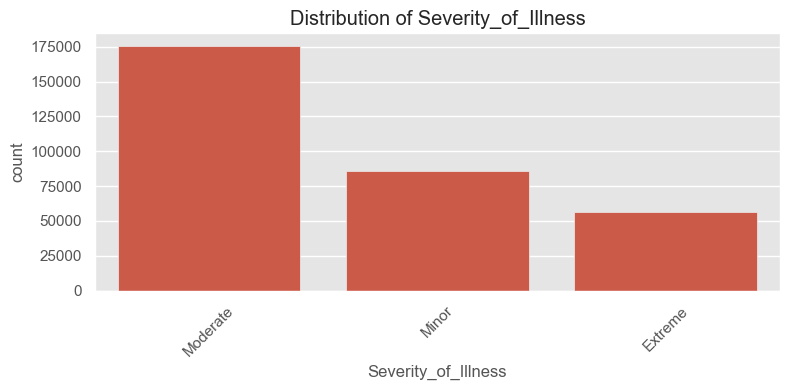

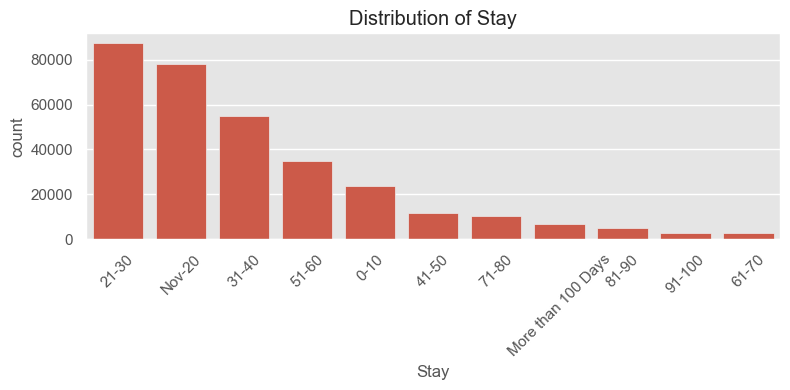

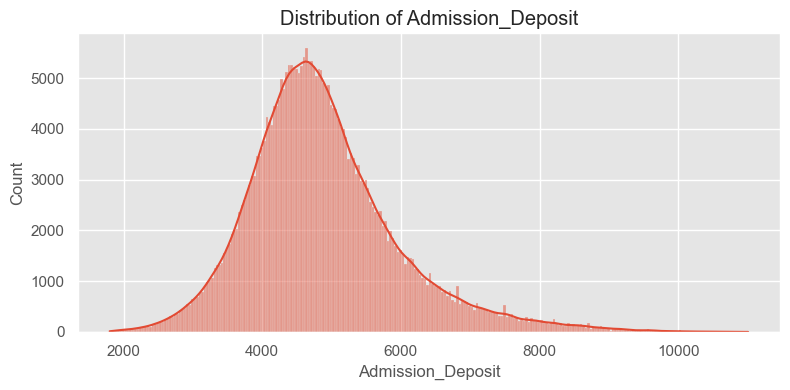

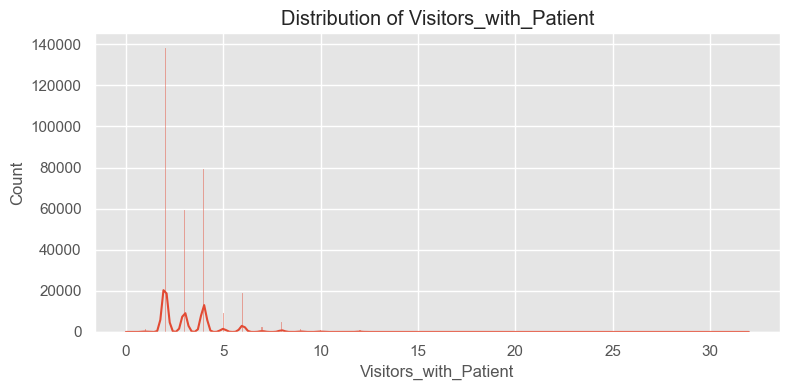

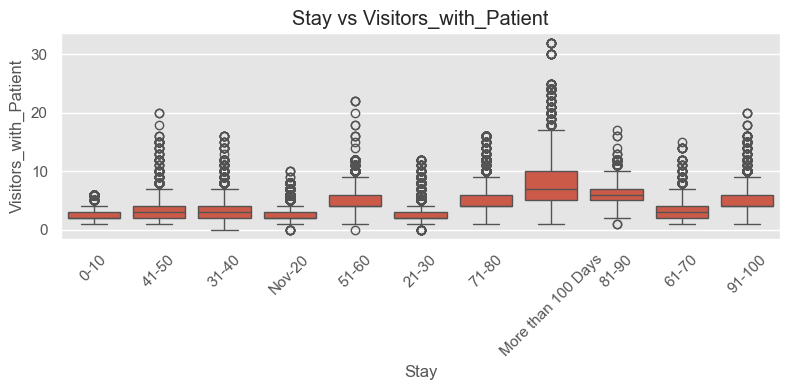

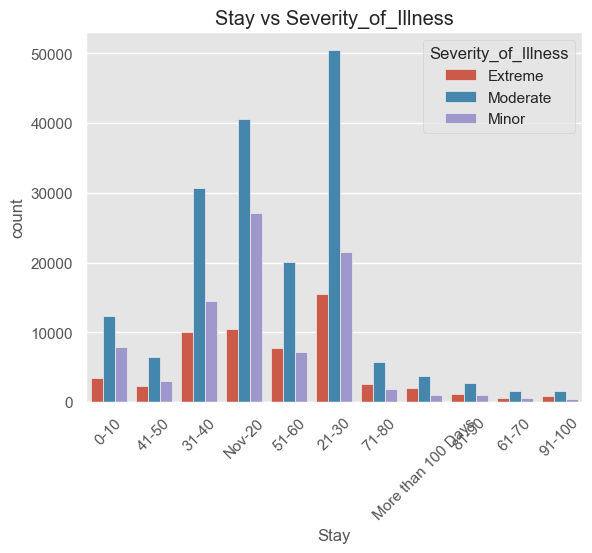

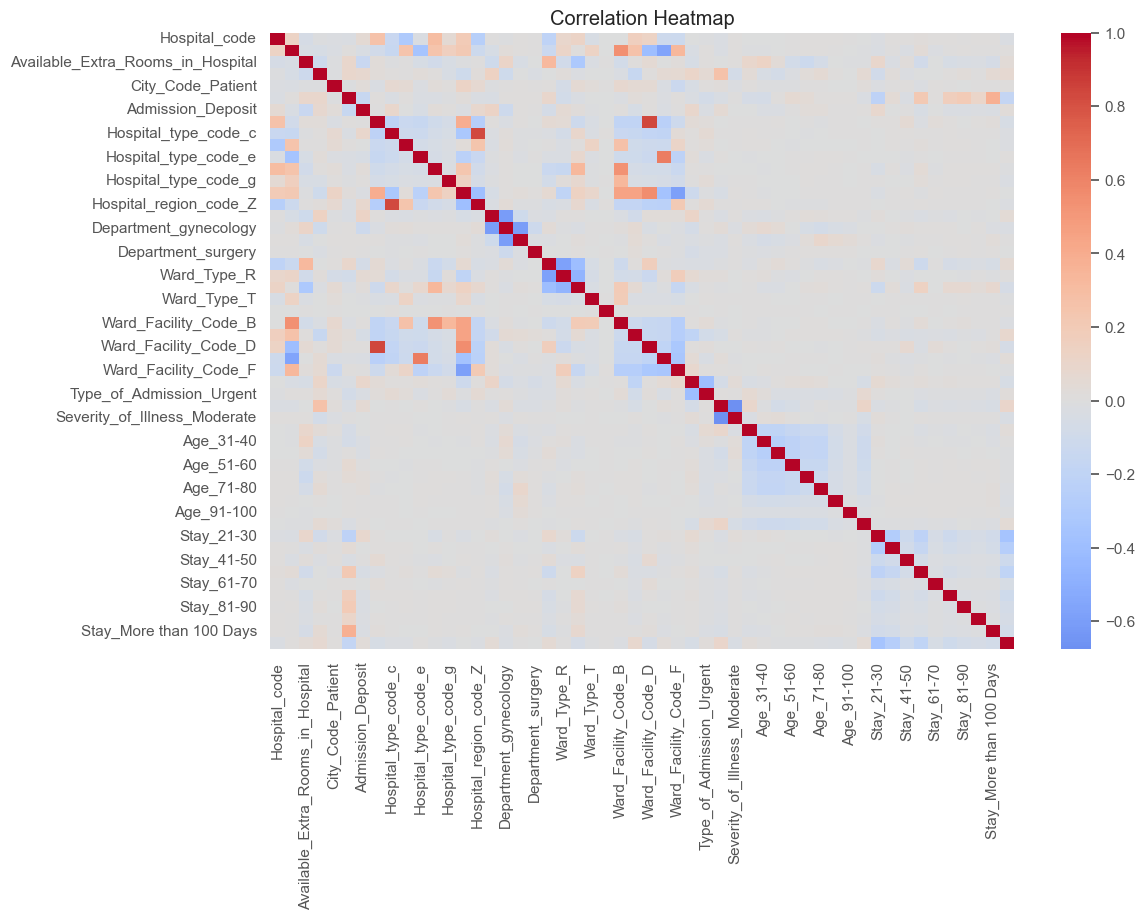

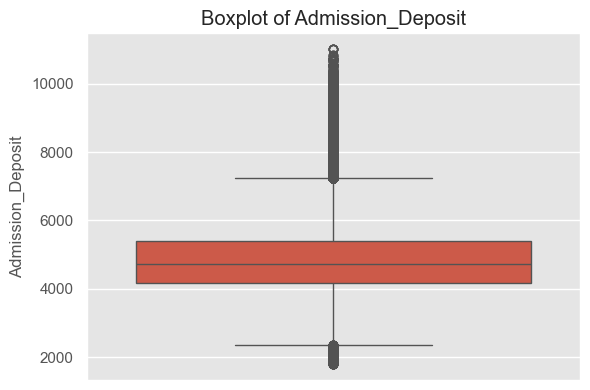

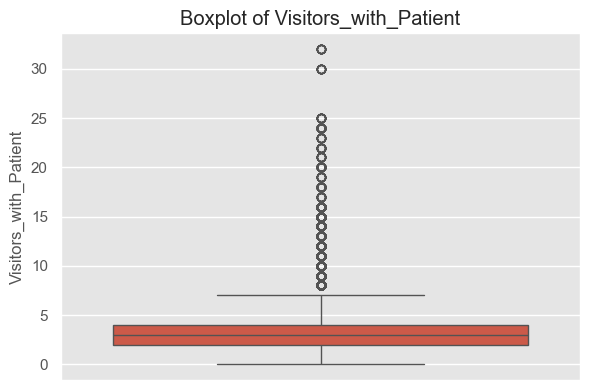


Categorical Features with High Cardinality:
Hospital_type_code: 7 unique values
Hospital_region_code: 3 unique values
Department: 5 unique values
Ward_Type: 6 unique values
Ward_Facility_Code: 6 unique values
Type_of_Admission: 3 unique values
Severity_of_Illness: 3 unique values
Age: 10 unique values
Stay: 11 unique values


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
df = pd.read_csv('HealthCareAnalytics.csv')  

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())

df['Bed_Grade'].fillna(df['Bed_Grade'].mode()[0], inplace=True)

knn_imputer = KNNImputer(n_neighbors=5)
df['City_Code_Patient'] = knn_imputer.fit_transform(df[['City_Code_Patient']])


cat_cols = ['Hospital_type_code', 'Department', 'Ward_Type',
            'Ward_Facility_Code', 'Type_of_Admission', 'Severity_of_Illness', 'Stay']

## drop unwanted cols
df.drop(['case_id', 'patientid'], axis=1, inplace=True)


for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

num_cols = ['Admission_Deposit', 'Visitors_with_Patient']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Stay vs Severity/Admission/Visitors
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Stay', y='Visitors_with_Patient')
plt.title("Stay vs Visitors_with_Patient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.countplot(data=df, x='Stay', hue='Severity_of_Illness')
plt.title('Stay vs Severity_of_Illness')
plt.xticks(rotation=45)
plt.show()


df_corr = df.copy()
df_corr = pd.get_dummies(df_corr, drop_first=True)
corr = df_corr.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()


print("\nCategorical Features with High Cardinality:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")

profile = ProfileReport(df, title="Hospital Stay EDA Report", explorative=True)
profile.to_file("eda_report.html")


### Base ML Model Building


 Classification Report:

                    precision    recall  f1-score   support

              0-10       0.37      0.17      0.24      4721
             11-20       0.43      0.49      0.46     15628
             21-30       0.42      0.66      0.52     17498
             31-40       0.41      0.23      0.29     11032
             41-50       0.14      0.00      0.01      2349
             51-60       0.40      0.49      0.44      7004
             61-70       0.04      0.00      0.00       549
             71-80       0.32      0.05      0.09      2051
             81-90       0.36      0.23      0.28       967
            91-100       0.22      0.03      0.05       553
More than 100 Days       0.55      0.42      0.48      1336

          accuracy                           0.42     63688
         macro avg       0.33      0.25      0.26     63688
      weighted avg       0.40      0.42      0.39     63688



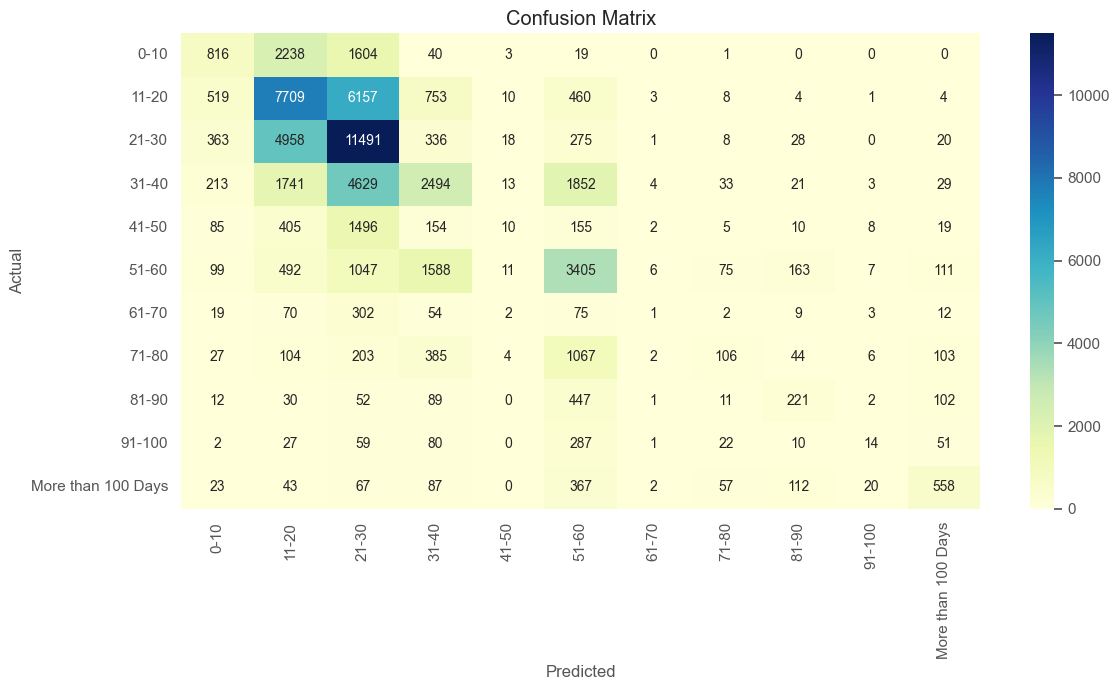

In [38]:
from sklearn.metrics import confusion_matrix
df['Stay'] = df['Stay'].replace('Nov-20', '11-20')

stay_order = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60',
              '61-70', '71-80', '81-90', '91-100', 'More than 100 Days']
df['Stay'] = pd.Categorical(df['Stay'], categories=stay_order, ordered=True)
df['Stay_Label'] = df['Stay'].cat.codes



categorical_cols = df.select_dtypes(include='object').columns.tolist()

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

X = df.drop(['Stay', 'Stay_Label'], axis=1)
y = df['Stay_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = XGBClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=stay_order))

plt.figure(figsize=(12, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=stay_order, yticklabels=stay_order, cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### Feature Importances

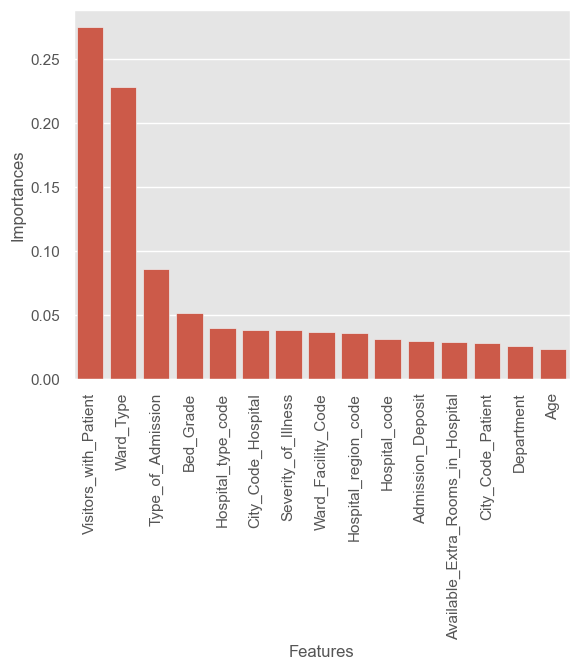

In [26]:
df1=pd.DataFrame({'Features':X_train.columns,'Importances':clf.feature_importances_})
df1=df1.sort_values(by='Importances',ascending=False)
sns.barplot(x=df1.Features,y=df1.Importances)
plt.xticks(rotation=90)
plt.show()

### Group/Bucket the Classes for better Metrics

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

bucket_map = {
    '0-10': 5,
    '11-20': 15,
    '21-30': 25,
    '31-40': 35,
    '41-50': 45,
    '51-60': 55,
    '61-70': 65,
    '71-80': 75,
    '81-90': 85,
    '91-100': 95,
    'More than 100 Days': 101
}

def rebin_days_bucket(x):
    if x <= 20:
        return '0-20'
    elif x <= 40:
        return '21-40'
    elif x <= 60:
        return '41-60'
    elif x <= 80:
        return '61-80'
    else:
        return '81+'

df['target_numeric'] = df['Stay'].map(bucket_map)
df['rebinned_target'] = df['target_numeric'].apply(rebin_days_bucket)

le = LabelEncoder()
df['rebinned_encoded'] = le.fit_transform(df['rebinned_target'])

X = df.drop(columns=['Stay','Stay_Label', 'target_numeric', 'rebinned_target', 'rebinned_encoded'])  
y = df['rebinned_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        0-20       0.53      0.50      0.51     20349
       21-40       0.55      0.65      0.59     28530
       41-60       0.41      0.34      0.37      9352
       61-80       0.27      0.07      0.11      2600
         81+       0.58      0.45      0.51      2857

    accuracy                           0.52     63688
   macro avg       0.47      0.40      0.42     63688
weighted avg       0.51      0.52      0.51     63688



In [28]:
df.columns

Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available_Extra_Rooms_in_Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed_Grade',
       'City_Code_Patient', 'Type_of_Admission', 'Severity_of_Illness',
       'Visitors_with_Patient', 'Age', 'Admission_Deposit', 'Stay',
       'target_numeric', 'rebinned_target', 'rebinned_encoded'],
      dtype='object')

## Hyperparameter Tuning , Selecting Best Model's

In [44]:
param_dist = {
    'n_estimators': [100, 200, 300,400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)


best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
              precision    recall  f1-score   support

        0-20       0.59      0.52      0.55     20349
       21-40       0.57      0.71      0.63     28530
       41-60       0.44      0.36      0.40      9352
       61-80       0.37      0.04      0.07      2600
         81+       0.63      0.45      0.52      2857

    accuracy                           0.56     63688
   macro avg       0.52      0.41      0.43     63688
weighted avg       0.55      0.56      0.54     63688



In [ ]:
models_params = {
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax',
                               num_class=len(le.classes_),
                               use_label_encoder=False,
                               eval_metric='mlogloss',
                               random_state=42),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 1, 5],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 1.5, 2]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(objective='multiclass', random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [5, 10, 20],
            'num_leaves': [15, 31, 63],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
}


best_score = -1
best_model = None
best_name = ''
results = {}

for name, mp in models_params.items():
    print(f"\nTraining {name}...")
    search = RandomizedSearchCV(
        estimator=mp['model'],
        param_distributions=mp['params'],
        n_iter=25,
        cv=5,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    
    clf = search.best_estimator_
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    results[name] = {
        'model': clf,
        'f1_macro': f1,
        'report': classification_report(y_test, y_pred, target_names=le.classes_)
    }
    
    print(f"F1 Macro Score for {name}: {f1:.4f}")
    
    if f1 > best_score:
        best_score = f1
        best_model = clf
        best_name = name


print(f"\n Best Model: {best_name} (F1-macro: {best_score:.4f})")
print(results[best_name]['report'])



Training XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


## Enhanced XGB Classifier

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    scale_pos_weight=[class_weight_dict[i] for i in range(len(le.classes_))]
)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


### Conclusion

* EDA revealed crucial insights into the nature of admissions and hospital operations.

* Binning the target variable significantly improved classification performance.

* XGBoost, with tuned hyperparameters, delivered the best F1-score across classes.

